In [ ]:
def su3_tensor3(p, q):
    """Tensor (p,q) with (1,0). Return list of resulting (p',q')."""
    results = []
    results.append((p + 1, q))  # add box to first row
    if p - 1 >= 0:
        results.append((p - 1, q + 1))  # add box to second row
    if q - 1 >= 0:
        results.append((p, q - 1))  # add box to third row (in sense of lowering q)
    return results

def num_boxes(p, q):
    """Total boxes (for SU(3), ignoring 3-column equivalence)."""
    return p + 2 * q

def generate_su3_irreps(nmax):
    irreps = {}  # (p,q) -> {'code': int, 'parents': set()}
    frontier = []

    # --- Base: purely symmetric and antisymmetric irreps ---
    for p in range(1, nmax + 1):
        if num_boxes(p, 0) <= nmax:
            irreps[(p, 0)] = {'code': 1, 'parents': set()}
            frontier.append((p, 0))
    for q in range(1, nmax + 1):
        if num_boxes(0, q) <= nmax:
            irreps[(0, q)] = {'code': 1, 'parents': set()}
            frontier.append((0, q))

    current_code = 1
    while frontier:
        new_frontier = []
        for (p, q) in frontier:
            for child in su3_tensor3(p, q):
                boxes = num_boxes(*child)
                if boxes > nmax:
                    continue
                if child not in irreps:
                    irreps[child] = {'code': current_code + 1, 'parents': {(p, q)}}
                    new_frontier.append(child)
                else:
                    irreps[child]['parents'].add((p, q))
                    irreps[child]['code'] = min(
                        irreps[child]['code'], current_code + 1
                    )
        frontier = new_frontier
        current_code += 1
        if not frontier:
            break

    result_list = sorted(
        [
            (data["code"], p, q, num_boxes(p, q), sorted(data["parents"]))
            for (p, q), data in irreps.items()
        ],
        key=lambda x: (x[0], x[3], x[1], x[2]),
    )
    return result_list



nmax = 10
reps = generate_su3_irreps(nmax)
print(f"SU(3) irreps up to {nmax} boxes:")
for code, p, q, boxes, parents in reps:
    print(f"code={code:2d}  (p,q)=({p},{q})  boxes={boxes:2d}  parents={parents}")


In [ ]:
from collections import defaultdict


def tensor_with_fundamental(diagram):
    """
    Tensor a Young diagram with one fundamental (add 1 box).
    diagram: tuple of 3 numbers (r1,r2,r3) with r1>=r2>=r3>=0
    Returns list of resulting diagrams (still sorted r1>=r2>=r3)
    """
    r1,r2,r3 = diagram
    candidates = [
        (r1+1, r2, r3),
        (r1, r2+1, r3),
        (r1, r2, r3+1)
    ]
    # Keep only valid non-increasing rows
    children = []
    for c in candidates:
        sorted_c = tuple(sorted(c, reverse=True))
        children.append(sorted_c)
    return children

def all_young_diagrams(n):
    """
    Generate all valid SU(3) Young diagrams (3-row tuples) with up to n boxes.
    Each diagram satisfies r1 >= r2 >= r3 >= 0 and r1+r2+r3 <= n.
    Returns a list of tuples (r1,r2,r3).
    0 boxes is excluded.
    """
    diagrams = []
    for r1 in range(1, n+1):
        for r2 in range(r1+1):
            for r3 in range(r2+1):
                if r1 + r2 + r3 <= n:
                    diagrams.append((r1,r2,r3))
    return diagrams

def build_young_1new_rule(nmax=5, verbose=True):
    """
    Iteratively build Young diagrams using the 1-new-unknown rule:
    - Only process a parent if its tensor product yields 0 or 1 unknown children.
    - Otherwise, skip the parent for now and come back later.
    """
    known = set()
    
    # Seeds: purely symmetric and antisymmetric diagrams
    seeds = []
    for p in range(1, nmax+1):
        diag = (p,0,0)
        known.add(diag)
        seeds.append(diag)
    
    known.add((1,1,0)) # antisymmetric 2-box
    seeds.append((1,1,0))
    known.add((1,1,1)) # antisymmetric 3-box (trivial)
    seeds.append((1,1,1))

    
    # Parents pending processing
    pending = set(seeds)

    print("known:", sorted(list(known), key=lambda x: (sum(x), x)))

    step = 0
    while pending:
        progress = False  # track if we added any new diagram this iteration
        for parent in sorted(pending, key=lambda x: (sum(x), x)):
            if sum(parent) >= nmax:
                pending.remove(parent)
                continue

            raw_children = tensor_with_fundamental(parent)
            children = list({tuple(c) for c in raw_children})  # deduplicate

            unknown_children = [c for c in children if c not in known]

            if len(unknown_children) <= 1:
                step += 1
                # Add unknown children if any
                for ch in unknown_children:
                    known.add(ch)
                    pending.add(ch)

                # Parent is processed
                pending.remove(parent)
                progress = True

                if verbose:
                    print(f"Step {step}: parent={parent}, children={children}, new={unknown_children}")
                # Only process one parent per outer iteration to respect 1-new rule
                break

        if not progress:
            # No parent could be processed under 1-new-unknown rule
            print("No further progress possible under 1-new rule.")
            print(f"Remaining parents: {pending}")
            print("Detailed remaining parents info:")
            for parent in sorted(pending, key=lambda x: (sum(x), x)):
                raw_children = tensor_with_fundamental(parent)
                children = list({tuple(c) for c in raw_children})
                unknown_children = [c for c in children if c not in known]
                print(f"parent={parent}, children={children}, new={unknown_children}")
            break
    return known


if __name__ == "__main__":
    nmax = 6
    known = build_young_1new_rule(nmax)
    print("\nFinal known Young diagrams:")
    for k in sorted(list(known), key=lambda x: (sum(x), x)):
        print(f"diagram={k}, boxes={sum(k)}")

    print("all possible diagrams up to nmax:")
    all_diagrams = all_young_diagrams(nmax)
    for d in all_diagrams:
        print(f"diagram={d}, boxes={sum(d)}")

    if set(known) == set(all_diagrams):
        print("Known diagrams match all possible diagrams!")
    else:
        print("Known diagrams do not match all possible diagrams!")
        print(f"Missing diagrams: {set(all_diagrams) - set(known)}")


In [ ]:
# 1new allowed each time 
def tensor_with_fundamental_dynkin(pq):
    """(p,q) ⊗ (1,0) -> possible children in Dynkin labels (p+1,q),(p-1,q+1),(p,q-1)."""
    p, q = pq
    candidates = [(p + 1, q), (p - 1, q + 1), (p, q - 1)]
    return [c for c in candidates if c[0] >= 0 and c[1] >= 0]

def boxes_from_dynkin(pq):
    """Number of boxes (after removing full 3-columns): p + 2*q"""
    p, q = pq
    return p + 2 * q

def build_young_1new_rule_dynkin_limited(nmax=6, verbose=True):
    """
    Build irreps in Dynkin (p,q) using 1-new-unknown rule, but only for irreps
    with p + 2*q <= nmax (i.e., truly coming from <= nmax boxes).
    """
    known = set()
    seeds = []

    # Seeds: pure symmetric (p,0) and pure antisymmetric (0,q) but only if boxes <= nmax
    for p in range(0, nmax + 1):
        if boxes_from_dynkin((p,0)) <= nmax:
            known.add((p, 0))
            seeds.append((p, 0))
    
    known.add((0, 1)) # antisymmetric 2-box
    seeds.append((0, 1))

    pending = set(seeds)
    step = 0

    if verbose:
        print("Initial known irreps:", sorted(known, key=lambda x:(boxes_from_dynkin(x), x)))

    while pending:
        progress = False
        # deterministic order: increasing box count then (p,q)
        for parent in sorted(pending, key=lambda x:(boxes_from_dynkin(x), x)):
            parent_boxes = boxes_from_dynkin(parent)
            # don't tensor parents that already have maximum boxes
            if parent_boxes >= nmax:
                pending.remove(parent)
                continue

            # generate children but only keep those whose box count <= nmax
            raw_children = tensor_with_fundamental_dynkin(parent)
            children = [c for c in raw_children if boxes_from_dynkin(c) <= nmax]

            # deduplicate children (set) and keep deterministic order
            children = sorted(set(children), key=lambda x:(boxes_from_dynkin(x), x))

            unknown_children = [c for c in children if c not in known]

            if len(unknown_children) <= 1:
                step += 1
                for ch in unknown_children:
                    known.add(ch)
                    pending.add(ch)
                pending.remove(parent)
                progress = True
                if verbose:
                    print(f"Step {step}: parent={parent}, children={children}, new={unknown_children}")
                break

        if not progress:
            if verbose:
                print("\nNo further progress possible under 1-new rule.")
                print(f"Remaining parents: {sorted(pending, key=lambda x:(boxes_from_dynkin(x), x))}")
                print("Detailed remaining parents info:")
                for parent in sorted(pending, key=lambda x:(boxes_from_dynkin(x), x)):
                    raw_children = tensor_with_fundamental_dynkin(parent)
                    children = [c for c in raw_children if boxes_from_dynkin(c) <= nmax]
                    unknown_children = [c for c in children if c not in known]
                    print(f"parent={parent}, children={children}, new={unknown_children}")
            break

    return known

if __name__ == "__main__":
    nmax = 6
    known = build_young_1new_rule_dynkin_limited(nmax, verbose=True)
    print("\nFinal known irreps (p,q) with boxcount <= nmax:")
    for k in sorted(known, key=lambda x:(boxes_from_dynkin(x), x)):
        print(f"{k}  boxes={boxes_from_dynkin(k)}")


In [ ]:
# --- consistency check ---
# all possible valid (p,q) up to nmax boxes
all_possible = [(p, q) for p in range(nmax + 1)
                for q in range(nmax + 1)
                if p >= 0 and q >= 0 and p + 2*q <= nmax]

missing = set(all_possible) - set(known)
extra = set(known) - set(all_possible)

print("\nAll possible irreps with ≤ nmax boxes:")
for pq in sorted(all_possible, key=lambda x: (x[0] + 2*x[1], x)):
    print(f"{pq}  boxes={pq[0] + 2*pq[1]}")

if not missing and not extra:
    print(f"\n✅ Known irreps exactly match all {len(all_possible)} possible ones up to {nmax} boxes!")
else:
    if missing:
        print(f"\n⚠️ Missing irreps ({len(missing)}): {sorted(missing)}")
    if extra:
        print(f"⚠️ Extra irreps ({len(extra)}): {sorted(extra)}")

In [ ]:
import math

def sym_basis_k(k, d=3):
    basis = []
    
    def generate(remain, parts):
        if len(parts) == d - 1:
            parts = parts + [remain]
            a, b, c = parts
            norm = math.sqrt(math.factorial(a) *
                             math.factorial(b) *
                             math.factorial(c) /
                             math.factorial(k))
            basis.append((tuple(parts), norm))
            return
        
        # iterate decreasing: try largest first -> yields lexicographic decreasing
        for i in range(remain, -1, -1):
            generate(remain - i, parts + [i])

    generate(k, [])
    return basis

# Test
for vec, norm in sym_basis_k(5):
    print(vec, norm)


In [2]:
import sympy as sp

def sym_basis_k_symbolic(k, d=3):
    basis = []
    
    # Factorials and sqrt become symbolic
    factorial = sp.factorial
    sqrt = sp.sqrt
    
    def generate(remain, parts):
        if len(parts) == d - 1:
            parts = parts + [remain]
            a, b, c = parts
            
            norm = sqrt(factorial(a) * factorial(b) * factorial(c) / factorial(k))
            basis.append((tuple(parts), sp.simplify(norm)))
            return
        
        for i in range(remain, -1, -1):
            generate(remain - i, parts + [i])

    generate(k, [])
    return basis

# Test
for vec, norm in sym_basis_k_symbolic(4):
    print(vec, norm)


(4, 0, 0) 1
(3, 1, 0) 1/2
(3, 0, 1) 1/2
(2, 2, 0) sqrt(6)/6
(2, 1, 1) sqrt(3)/6
(2, 0, 2) sqrt(6)/6
(1, 3, 0) 1/2
(1, 2, 1) sqrt(3)/6
(1, 1, 2) sqrt(3)/6
(1, 0, 3) 1/2
(0, 4, 0) 1
(0, 3, 1) 1/2
(0, 2, 2) sqrt(6)/6
(0, 1, 3) 1/2
(0, 0, 4) 1


In [ ]:
import itertools

def print_basis_vector(vec, norm):
    """
    vec = (a,b,c) multiplicities
    norm = normalization scalar
    """
    a, b, c = vec

    # Build list of basis indices like [1,1,2,...]
    indices = [1]*a + [2]*b + [3]*c

    # Unique permutations -> distinct symmetric terms
    perms = sorted(set(itertools.permutations(indices)))

    # Build tensor-product expression
    terms = []
    for p in perms:
        term = " ⊗ ".join(f"e{idx}" for idx in p)
        terms.append(term)

    # Print result
    print(f"{norm:} * ( " + " + ".join(terms) + " )\n")

In [ ]:
for vec, norm in sym_basis_k_symbolic(4):
    print_basis_vector(vec, norm)

In [ ]:
import sympy as sp
import itertools

def pi_symmetric_symbolic(M, basis):
    """
    Compute the symmetric representation matrix pi(M)
    using the symbolic basis returned by sym_basis_k_symbolic,
    which already contains the correct normalization factors.
    
    M: 3x3 sympy matrix
    basis: list of (vec, norm) tuples from sym_basis_k_symbolic
    returns: piM as sympy.Matrix
    """
    n = len(basis)
    piM = sp.zeros(n, n)
    
    for j, (vec_j, norm_j) in enumerate(basis):
        # generate distinct permutations of indices for basis vector j
        indices_j = [i for i, count in enumerate(vec_j) for _ in range(count)]
        perms_j = set(itertools.permutations(indices_j))
        
        for k, (vec_k, norm_k) in enumerate(basis):
            if sum(vec_j) != sum(vec_k):
                continue  # different k, cannot match
            
            indices_k = [i for i, count in enumerate(vec_k) for _ in range(count)]
            perms_k = set(itertools.permutations(indices_k))
            
            val = 0
            for pj in perms_j:
                for pk in perms_k:
                    prod = 1
                    for r, c in zip(pj, pk):
                        prod *= M[r, c]
                    val += prod
            
            # multiply by the symbolic normalization factors from the basis
            piM[j, k] = sp.simplify(norm_j * norm_k * val)
    
    return piM


In [ ]:
# symbolic 3x3 matrix
M = sp.Matrix([[sp.symbols('m11'), sp.symbols('m12'), sp.symbols('m13')],
               [sp.symbols('m21'), sp.symbols('m22'), sp.symbols('m23')],
               [sp.symbols('m31'), sp.symbols('m32'), sp.symbols('m33')]])


basis = sym_basis_k_symbolic(5)

piM = pi_symmetric_symbolic(M, basis)
display(piM)


In [ ]:
def pi_symmetric_symbolic_tensor(M, basis):
    n = len(basis)
    piM = sp.zeros(n, n)
    
    basis_with_perms = []
    for vec, norm in basis:
        indices = [i for i, count in enumerate(vec) for _ in range(count)]
        perms = list(set(itertools.permutations(indices)))
        basis_with_perms.append((vec, norm, perms))
    
    for j, (vec_j, norm_j, perms_j) in enumerate(basis_with_perms):
        k_val = sum(vec_j)
        
        for k, (vec_k, norm_k, perms_k) in enumerate(basis_with_perms):
            if sum(vec_k) != k_val:
                continue
                
            # Use sum of products directly
            val = sum(
                sp.prod(M[pj_i, pk_i] for pj_i, pk_i in zip(pj, pk))
                for pj in perms_j for pk in perms_k
            )
            
            piM[j, k] = sp.simplify(norm_j * norm_k * val)
    
    return piM

basis = sym_basis_k_symbolic(5)

piM = pi_symmetric_symbolic_tensor(M, basis)
display(piM)

In [ ]:
from functools import lru_cache

@lru_cache(maxsize=None)
def get_permutations(vec_tuple):
    """Convert vector to tuple for caching"""
    vec = list(vec_tuple)
    indices = [i for i, count in enumerate(vec) for _ in range(count)]
    return list(set(itertools.permutations(indices)))

def pi_symmetric_symbolic_memoized(M, basis):
    n = len(basis)
    piM = sp.zeros(n, n)
    
    # Convert basis to cacheable format and precompute
    basis_precomputed = []
    for vec, norm in basis:
        perms = get_permutations(tuple(vec))
        basis_precomputed.append((vec, norm, perms))
    
    # Group by k value to avoid repeated sum calculations
    from collections import defaultdict
    basis_by_k = defaultdict(list)
    for idx, (vec, norm, perms) in enumerate(basis_precomputed):
        k_val = sum(vec)
        basis_by_k[k_val].append((idx, vec, norm, perms))
    
    # Process by k groups
    for k_val, group in basis_by_k.items():
        for j_data in group:
            j, vec_j, norm_j, perms_j = j_data
            
            for k_data in group:
                k, vec_k, norm_k, perms_k = k_data
                if k < j:  # Skip if we'll compute in transpose
                    continue
                    
                val = 0
                for pj in perms_j:
                    for pk in perms_k:
                        prod = 1
                        for r, c in zip(pj, pk):
                            prod *= M[r, c]
                        val += prod
                
                result = (norm_j * norm_k * val) # sp.simplify(norm_j * norm_k * val)
                piM[j, k] = result
                if j != k:  # Use symmetry
                    piM[k, j] = result
    
    return piM

basis = sym_basis_k_symbolic(6)
piM = pi_symmetric_symbolic_memoized(M, basis)
display(piM)

In [ ]:
import itertools
import sympy as sp
from functools import lru_cache
from collections import defaultdict

# --- Memoized permutations ---
@lru_cache(maxsize=None)
def get_permutations(vec_tuple):
    vec = list(vec_tuple)
    indices = [i for i, count in enumerate(vec) for _ in range(count)]
    return list(set(itertools.permutations(indices)))

# --- Symmetric pi with multiplication counting ---
def pi_symmetric_count_mul(M, basis):
    n = len(basis)
    piM = sp.zeros(n, n)
    
    basis_precomputed = []
    for vec, norm in basis:
        perms = get_permutations(tuple(vec))
        basis_precomputed.append((vec, norm, perms))
    
    basis_by_k = defaultdict(list)
    for idx, (vec, norm, perms) in enumerate(basis_precomputed):
        k_val = sum(vec)
        basis_by_k[k_val].append((idx, vec, norm, perms))
    
    total_mults = 0
    
    for k_val, group in basis_by_k.items():
        for j_data in group:
            j, vec_j, norm_j, perms_j = j_data
            for k_data in group:
                k, vec_k, norm_k, perms_k = k_data
                if k < j:
                    continue
                
                val = 0
                for pj in perms_j:
                    for pk in perms_k:
                        prod = 1
                        for r, c in zip(pj, pk):
                            prod *= M[r, c]
                            total_mults += 1  # count each multiplication
                        val += prod
                
                result = norm_j * norm_k * val
                piM[j, k] = result
                if j != k:
                    piM[k, j] = result
    
    print(f"Total symbolic multiplications: {total_mults}")
    return piM

# --- Basis generator ---
def sym_basis_k_symbolic(k, d=3):
    basis = []
    factorial = sp.factorial
    sqrt = sp.sqrt

    def generate(remain, parts):
        if len(parts) == d - 1:
            parts = parts + [remain]
            a, b, c = parts
            norm = sqrt(factorial(a) * factorial(b) * factorial(c) / factorial(k))
            basis.append((tuple(parts), sp.simplify(norm)))
            return
        for i in range(remain, -1, -1):
            generate(remain - i, parts + [i])

    generate(k, [])
    return basis

# --- Test ---
d = 3
k_val = 6
M = sp.Matrix([[sp.symbols(f'M{i}{j}') for j in range(d)] for i in range(d)])
basis = sym_basis_k_symbolic(k_val, d)
piM = pi_symmetric_count_mul(M, basis)


In [5]:
import sympy as sp
from functools import lru_cache
from collections import defaultdict

# ---------------------------
# Basis generator
# ---------------------------
def sym_basis_k_symbolic(k, d=3):
    basis = []
    factorial = sp.factorial
    sqrt = sp.sqrt

    def generate(remain, parts):
        if len(parts) == d - 1:
            parts = parts + [remain]
            norm = sqrt(sp.prod(factorial(p) for p in parts) / factorial(k))
            basis.append((tuple(parts), sp.simplify(norm)))
            return
        for i in range(remain, -1, -1):
            generate(remain - i, parts + [i])

    generate(k, [])
    return basis

# ---------------------------
# Contingency matrices
# ---------------------------
def enumerate_contingency_matrices(rows, cols):
    d = len(rows)
    assert len(cols) == d
    assert sum(rows) == sum(cols)

    @lru_cache(maxsize=None)
    def _recurse(row_idx, cols_remaining):
        cols_remaining = list(cols_remaining)
        if row_idx == d:
            if all(c == 0 for c in cols_remaining):
                return [()]
            else:
                return []
        results = []
        target = rows[row_idx]

        def compose(pos, left, current):
            if pos == d - 1:
                val = left
                if val <= cols_remaining[pos]:
                    yield tuple(current + [val])
                return
            maxv = min(left, cols_remaining[pos])
            for v in range(maxv, -1, -1):
                yield from compose(pos + 1, left - v, current + [v])

        for row_choice in compose(0, target, []):
            new_cols = tuple(cols_remaining[j] - row_choice[j] for j in range(d))
            for tail in _recurse(row_idx + 1, new_cols):
                results.append(tuple(row_choice) + tail)
        return results

    for mat_flat in _recurse(0, tuple(cols)):
        yield mat_flat

# ---------------------------
# Symmetric projection
# ---------------------------
def pi_symmetric_multinomial(M, basis):
    d = M.rows
    assert M.cols == d
    n = len(basis)
    piM = sp.zeros(n, n)
    factorial = sp.factorial

    # Precompute basis grouped by total degree k
    basis_by_k = defaultdict(list)
    for idx, (vec, norm) in enumerate(basis):
        k = sum(vec)
        basis_by_k[k].append((idx, vec, sp.simplify(norm)))

    # Compute each block for degree k
    for k_val, group in basis_by_k.items():
        k_fact = factorial(k_val)
        for i_idx, vec_i, norm_i in group:
            for j_idx, vec_j, norm_j in group:
                val = 0
                # enumerate valid contingency matrices
                for mat_flat in enumerate_contingency_matrices(vec_i, vec_j):
                    term = 1
                    denom = 1
                    for u in range(d):
                        for v in range(d):
                            t = mat_flat[u * d + v]
                            if t:
                                denom *= factorial(t)
                                term *= M[u, v] ** t
                    val += k_fact / denom * term
                piM[i_idx, j_idx] = norm_i * norm_j * val

    return piM

# ---------------------------
# Test for k=1
# ---------------------------
d = 3
k_val = 8
M = sp.Matrix([[sp.symbols('m11'), sp.symbols('m12'), sp.symbols('m13')],
               [sp.symbols('m21'), sp.symbols('m22'), sp.symbols('m23')],
               [sp.symbols('m31'), sp.symbols('m32'), sp.symbols('m33')]])
basis = sym_basis_k_symbolic(k_val, d)
piM = pi_symmetric_multinomial(M, basis)
display(piM)


Matrix([
[                          m11**8,                                                                                      2*sqrt(2)*m11**7*m12,                                                                                      2*sqrt(2)*m11**7*m13,                                                                                                                                                                                      2*sqrt(7)*m11**6*m12**2,                                                                                                                                                                                                                                                                                               2*sqrt(14)*m11**6*m12*m13,                                                                                                                                                                                      2*sqrt(7)*m11**6*m13**2,                  

In [6]:
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()

# run the code you want to profile
piM = pi_symmetric_multinomial(M, basis)

profiler.disable()
stats = pstats.Stats(profiler).sort_stats("cumulative")
stats.print_stats(20)  # print top 20 functions by cumulative time


         24400785 function calls (22292700 primitive calls) in 8.043 seconds

   Ordered by: cumulative time
   List reduced from 457 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   146661    0.104    0.000    7.326    0.000 c:\Users\martin\anaconda3\Lib\site-packages\sympy\core\decorators.py:224(_func)
   146661    0.072    0.000    7.010    0.000 c:\Users\martin\anaconda3\Lib\site-packages\sympy\core\decorators.py:99(binary_op_wrapper)
749227/366700    0.355    0.000    6.926    0.000 c:\Users\martin\anaconda3\Lib\site-packages\sympy\core\cache.py:69(wrapper)
48882/48129    0.279    0.000    6.394    0.000 c:\Users\martin\anaconda3\Lib\site-packages\sympy\core\operations.py:52(__new__)
    62544    0.030    0.000    4.475    0.000 c:\Users\martin\anaconda3\Lib\site-packages\sympy\core\expr.py:216(__mul__)
35278/35030    0.660    0.000    3.565    0.000 c:\Users\martin\anaconda3\Lib\site-packages\sympy\core\mul.py:195(flatten)


In [ ]:
import sympy as sp
import random

# assume these functions are already defined from previous code:
# - sym_basis_k_symbolic
# - pi_symmetric_multinomial

def random_int_matrix(d, lo=-3, hi=3):
    """Generate a random integer dxd SymPy matrix."""
    return sp.Matrix([[random.randint(lo, hi) for _ in range(d)] for _ in range(d)])


def test_representation_property(d=3, k_val=4, trials=3):
    print(f"Testing π(AB) = π(A) π(B) for S^{k_val}(ℂ^{d}) ...\n")

    # fixed basis for this k and d
    basis = sym_basis_k_symbolic(k_val, d)

    for t in range(trials):
        print(f"--- Trial {t+1} ---")

        # Random integer matrices A, B
        A = random_int_matrix(d)
        B = random_int_matrix(d)
        AB = A * B

        print("A =", A)
        print("B =", B)

        # Compute symmetric power matrices
        piA = pi_symmetric_multinomial(A, basis)
        piB = pi_symmetric_multinomial(B, basis)
        piAB = pi_symmetric_multinomial(AB, basis)

        # Compare
        diff = sp.simplify(piAB - (piA * piB))

        if diff == sp.zeros(*diff.shape):
            print("✅ PASS:  pi(AB) == pi(A)*pi(B)")
        else:
            print("❌ FAIL!")
            print("Difference:")
            display(diff)
            return False  # early stop

    print("\nAll tests passed ✅")
    return True


# Run the property test
if __name__ == "__main__":
    random.seed(0)
    test_representation_property(d=3, k_val=10, trials=3)


In [ ]:
import sympy as sp
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

# Assume sym_basis_k_symbolic and pi_symmetric_multinomial are already defined
d = 3
M = sp.Matrix([[sp.symbols(f"m{i+1}{j+1}") for j in range(d)] for i in range(d)])

k_values = list(range(1, 21))
times = []

plt.figure(figsize=(8,5))

for k_val in k_values:
    start = time.time()
    
    basis = sym_basis_k_symbolic(k_val, d)
    piM = pi_symmetric_multinomial(M, basis)
    
    elapsed = time.time() - start
    times.append(elapsed)
    
    # Clear previous plot
    clear_output(wait=True)
    
    # Plot updated data
    plt.plot(k_values[:len(times)], times, 'o-', color='blue', label="Time to compute piM")
    plt.xlabel("k value")
    plt.ylabel("Time (seconds)")
    plt.title("Computation time of piM vs k")
    plt.grid(True)
    plt.legend()
    plt.xlim(1, 20)
    plt.ylim(0, max(times)*1.2)
    plt.show()


In [ ]:
import sympy as sp
from math import factorial
from sympy import factorial, prod

def pi_symmetric_d3(M, basis):
    n = len(basis)
    piM = sp.zeros(n, n)
    
    for i_idx, (p, norm_i) in enumerate(basis):
        for j_idx, (q, norm_j) in enumerate(basis):
            k = sum(p)
            val = 0
            # Iterate over free variables t11, t12, t21, t22
            for t11 in range(min(p[0], q[0])+1):
                for t12 in range(min(p[0]-t11, q[1])+1):
                    t13 = p[0] - t11 - t12
                    if t13 < 0 or t13 > q[2]:
                        continue
                    for t21 in range(min(p[1], q[0]-t11)+1):
                        for t22 in range(min(p[1]-t21, q[1]-t12)+1):
                            t23 = p[1] - t21 - t22
                            t31 = q[0] - t11 - t21
                            t32 = q[1] - t12 - t22
                            t33 = q[2] - t13 - t23
                            if min(t13,t23,t31,t32,t33) < 0:
                                continue
                            # Compute multinomial weight
                            t_list = [t11,t12,t13,t21,t22,t23,t31,t32,t33]
                            weight = factorial(k) / prod(factorial(t) for t in t_list)
                            term = sp.prod(M[u,v]**t_list[u*3+v] for u in range(3) for v in range(3))
                            val += weight * term
            piM[i_idx,j_idx] = norm_i*norm_j*val
    return piM
d = 3
k_val = 2
M = sp.Matrix([[sp.symbols('m11'), sp.symbols('m12'), sp.symbols('m13')],
               [sp.symbols('m21'), sp.symbols('m22'), sp.symbols('m23')],
               [sp.symbols('m31'), sp.symbols('m32'), sp.symbols('m33')]])
basis = sym_basis_k_symbolic(k_val, d)
piM = pi_symmetric_d3(M, basis)
display(piM)

In [ ]:
import sympy as sp
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output


d = 3
M = sp.Matrix([[sp.symbols(f"m{i+1}{j+1}") for j in range(d)] for i in range(d)])

k_values = list(range(1, 21))
times = []

plt.figure(figsize=(8,5))

for k_val in k_values:
    start = time.time()
    
    basis = sym_basis_k_symbolic(k_val, d)
    piM = pi_symmetric_d3(M, basis)
    
    elapsed = time.time() - start
    times.append(elapsed)
    
    # Clear previous plot
    clear_output(wait=True)
    
    # Plot updated data
    plt.plot(k_values[:len(times)], times, 'o-', color='blue', label="Time to compute piM")
    plt.xlabel("k value")
    plt.ylabel("Time (seconds)")
    plt.title("Computation time of piM vs k")
    plt.grid(True)
    plt.legend()
    plt.xlim(1, 20)
    plt.ylim(0, max(times)*1.2)
    plt.show()

In [ ]:
import sympy as sp
from functools import lru_cache
from collections import defaultdict
from itertools import product

# ---------------------------
# Basis generator
# ---------------------------
def sym_basis_k_symbolic(k, d=3):
    basis = []
    factorial = sp.factorial
    sqrt = sp.sqrt

    def generate(remain, parts):
        if len(parts) == d - 1:
            parts = parts + [remain]
            norm = sqrt(sp.prod(factorial(p) for p in parts) / factorial(k))
            basis.append((tuple(parts), sp.simplify(norm)))
            return
        for i in range(remain, -1, -1):
            generate(remain - i, parts + [i])

    generate(k, [])
    return basis

# ---------------------------
# Contingency matrices
# ---------------------------
def enumerate_contingency_matrices(rows, cols):
    d = len(rows)
    assert len(cols) == d
    assert sum(rows) == sum(cols)

    @lru_cache(maxsize=None)
    def _recurse(row_idx, cols_remaining):
        cols_remaining = list(cols_remaining)
        if row_idx == d:
            if all(c == 0 for c in cols_remaining):
                return [()]
            else:
                return []
        results = []
        target = rows[row_idx]

        def compose(pos, left, current):
            if pos == d - 1:
                val = left
                if val <= cols_remaining[pos]:
                    yield tuple(current + [val])
                return
            maxv = min(left, cols_remaining[pos])
            for v in range(maxv, -1, -1):
                yield from compose(pos + 1, left - v, current + [v])

        for row_choice in compose(0, target, []):
            new_cols = tuple(cols_remaining[j] - row_choice[j] for j in range(d))
            for tail in _recurse(row_idx + 1, new_cols):
                results.append(tuple(row_choice) + tail)
        return results

    for mat_flat in _recurse(0, tuple(cols)):
        yield mat_flat

# ---------------------------
# Symmetric projection with factorial/power cache
# ---------------------------
def pi_symmetric_multinomial_cached(M, basis):
    d = M.rows
    assert M.cols == d
    n = len(basis)
    piM = sp.zeros(n, n)
    factorial = sp.factorial

    # Precompute basis grouped by total degree k
    basis_by_k = defaultdict(list)
    for idx, (vec, norm) in enumerate(basis):
        k = sum(vec)
        basis_by_k[k].append((idx, vec, sp.simplify(norm)))

    # Precompute factorials 0..k_max for caching
    k_max = max(sum(vec) for vec, _ in basis)
    factorial_cache = [factorial(i) for i in range(k_max + 1)]

    # Precompute powers of M[u,v] for t = 1..k_max
    power_cache = {}
    for u in range(d):
        for v in range(d):
            for t in range(1, k_max + 1):
                power_cache[(u,v,t)] = M[u,v]**t

    # Compute each block for degree k
    for k_val, group in basis_by_k.items():
        k_fact = factorial_cache[k_val]
        for i_idx, vec_i, norm_i in group:
            for j_idx, vec_j, norm_j in group:
                val = 0
                # enumerate valid contingency matrices
                for mat_flat in enumerate_contingency_matrices(vec_i, vec_j):
                    term = 1
                    denom = 1
                    for u in range(d):
                        for v in range(d):
                            t = mat_flat[u * d + v]
                            if t:
                                denom *= factorial_cache[t]       # use cached factorial
                                term *= power_cache[(u,v,t)]     # use cached power
                    val += k_fact / denom * term
                piM[i_idx, j_idx] = norm_i * norm_j * val

    return piM

# ---------------------------
# Test for k=2
# ---------------------------
d = 3
k_val = 2
M = sp.Matrix([[sp.symbols('m11'), sp.symbols('m12'), sp.symbols('m13')],
               [sp.symbols('m21'), sp.symbols('m22'), sp.symbols('m23')],
               [sp.symbols('m31'), sp.symbols('m32'), sp.symbols('m33')]])
basis = sym_basis_k_symbolic(k_val, d)
piM = pi_symmetric_multinomial_cached(M, basis)
display(piM)


In [ ]:
import sympy as sp
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output


d = 3
M = sp.Matrix([[sp.symbols(f"m{i+1}{j+1}") for j in range(d)] for i in range(d)])

k_values = list(range(1, 21))
times = []

plt.figure(figsize=(8,5))

for k_val in k_values:
    start = time.time()
    
    basis = sym_basis_k_symbolic(k_val, d)
    piM = pi_symmetric_multinomial_cached(M, basis)
    
    elapsed = time.time() - start
    times.append(elapsed)
    
    # Clear previous plot
    clear_output(wait=True)
    
    # Plot updated data
    plt.plot(k_values[:len(times)], times, 'o-', color='blue', label="Time to compute piM")
    plt.xlabel("k value")
    plt.ylabel("Time (seconds)")
    plt.title("Computation time of piM vs k")
    plt.grid(True)
    plt.legend()
    plt.xlim(1, 20)
    plt.ylim(0, max(times)*1.2)
    plt.show()

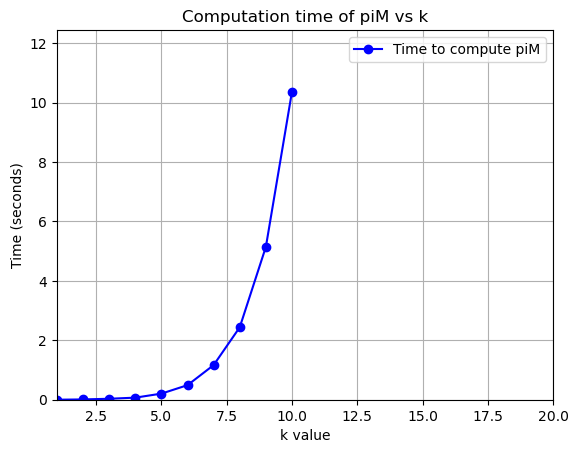

KeyboardInterrupt: 

In [ ]:
import sympy as sp
from collections import defaultdict
from functools import lru_cache
from itertools import product

def pi_symmetric_multinomial_opt(M, basis, numeric=False):
    """
    Compute the symmetric multinomial projection of M on the given basis.

    Args:
        M (sp.Matrix): d x d symbolic matrix.
        basis (list): List of (vector, norm) tuples from sym_basis_k_symbolic.
        numeric (bool): If True, evaluates numerically to speed up large k.

    Returns:
        sp.Matrix: Projected matrix.
    """
    d = M.rows
    n = len(basis)
    piM = sp.zeros(n, n)
    factorial = sp.factorial

    # Precompute factorials up to max k
    max_k = max(sum(vec) for vec, _ in basis)
    factorials = [factorial(i) for i in range(max_k + 1)]

    # Group basis by total degree k
    basis_by_k = defaultdict(list)
    for idx, (vec, norm) in enumerate(basis):
        k = sum(vec)
        basis_by_k[k].append((idx, vec, norm))

    # Precompute M powers
    max_power = max_k
    powers = {}
    for u in range(d):
        for v in range(d):
            powers[(u, v)] = [1]  # M[u,v]**0
            val = 1
            for t in range(1, max_power + 1):
                val *= M[u, v]
                powers[(u, v)].append(val)

    # Function to enumerate contingency matrices
    def enum_contingency(rows, cols):
        @lru_cache(maxsize=None)
        def _recurse(row_idx, cols_remaining):
            cols_remaining = list(cols_remaining)
            if row_idx == len(rows):
                if all(c == 0 for c in cols_remaining):
                    return [()]
                return []
            results = []
            target = rows[row_idx]

            def compose(pos, left, current):
                if pos == len(cols_remaining) - 1:
                    val = left
                    if val <= cols_remaining[pos]:
                        yield tuple(current + [val])
                    return
                maxv = min(left, cols_remaining[pos])
                for v in range(maxv, -1, -1):
                    yield from compose(pos + 1, left - v, current + [v])

            for row_choice in compose(0, target, []):
                new_cols = tuple(cols_remaining[j] - row_choice[j] for j in range(len(cols_remaining)))
                for tail in _recurse(row_idx + 1, new_cols):
                    results.append(tuple(row_choice) + tail)
            return results

        return _recurse(0, tuple(cols))

    # Compute projection
    for k_val, group in basis_by_k.items():
        k_fact = factorials[k_val]
        for i_idx, vec_i, norm_i in group:
            for j_idx, vec_j, norm_j in group:
                val = 0
                for mat_flat in enum_contingency(tuple(vec_i), tuple(vec_j)):
                    term = 1
                    denom = 1
                    for u in range(d):
                        for v in range(d):
                            t = mat_flat[u * d + v]
                            if t:
                                term *= powers[(u, v)][t]
                                denom *= factorials[t]
                    val += k_fact / denom * term
                piM[i_idx, j_idx] = norm_i * norm_j * val
                if numeric:
                    piM[i_idx, j_idx] = sp.N(piM[i_idx, j_idx])

    return piM



In [ ]:


import sympy as sp
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output


d = 3
M = sp.Matrix([[sp.symbols(f"m{i+1}{j+1}") for j in range(d)] for i in range(d)])

k_values = list(range(1, 21))
times = []

plt.figure(figsize=(8,5))

for k_val in k_values:
    start = time.time()
    
    basis = sym_basis_k_symbolic(k_val, d)
    piM = pi_symmetric_multinomial_opt(M, basis)
    
    elapsed = time.time() - start
    times.append(elapsed)
    
    # Clear previous plot
    clear_output(wait=True)
    
    # Plot updated data
    plt.plot(k_values[:len(times)], times, 'o-', color='blue', label="Time to compute piM")
    plt.xlabel("k value")
    plt.ylabel("Time (seconds)")
    plt.title("Computation time of piM vs k")
    plt.grid(True)
    plt.legend()
    plt.xlim(1, 20)
    plt.ylim(0, max(times)*1.2)
    plt.show()

In [3]:
import sympy as sp
import random

# assume these functions are already defined from previous code:
# - sym_basis_k_symbolic
# - pi_symmetric_multinomial

def random_int_matrix(d, lo=-3, hi=3):
    """Generate a random integer dxd SymPy matrix."""
    return sp.Matrix([[random.randint(lo, hi) for _ in range(d)] for _ in range(d)])


def test_representation_property(d=3, k_val=4, trials=3):
    print(f"Testing π(AB) = π(A) π(B) for S^{k_val}(ℂ^{d}) ...\n")

    # fixed basis for this k and d
    basis = sym_basis_k_symbolic(k_val, d)

    for t in range(trials):
        print(f"--- Trial {t+1} ---")

        # Random integer matrices A, B
        A = random_int_matrix(d)
        B = random_int_matrix(d)
        AB = A * B

        print("A =", A)
        print("B =", B)

        # Compute symmetric power matrices
        piA = pi_symmetric_multinomial_opt(A, basis)
        piB = pi_symmetric_multinomial_opt(B, basis)
        piAB = pi_symmetric_multinomial_opt(AB, basis)

        # Compare
        diff = sp.simplify(piAB - (piA * piB))

        if diff == sp.zeros(*diff.shape):
            print("✅ PASS:  pi(AB) == pi(A)*pi(B)")
        else:
            print("❌ FAIL!")
            print("Difference:")
            display(diff)
            return False  # early stop

    print("\nAll tests passed ✅")
    return True


# Run the property test
if __name__ == "__main__":
    random.seed(0)
    test_representation_property(d=3, k_val=10, trials=3)


Testing π(AB) = π(A) π(B) for S^10(ℂ^3) ...

--- Trial 1 ---
A = Matrix([[3, 0, 3], [0, -3, -1], [1, 0, 0]])
B = Matrix([[3, 3, -1], [0, -1, 1], [-2, 1, -2]])
✅ PASS:  pi(AB) == pi(A)*pi(B)
--- Trial 2 ---
A = Matrix([[-1, -2, 3], [-3, 1, 3], [-1, 1, 2]])
B = Matrix([[3, 1, -2], [-1, -3, 2], [-3, 3, 2]])
✅ PASS:  pi(AB) == pi(A)*pi(B)
--- Trial 3 ---
A = Matrix([[-1, 0, 1], [-3, -1, 0], [-1, 1, 2]])
B = Matrix([[-2, 1, 0], [0, 3, 1], [-1, -3, 3]])
✅ PASS:  pi(AB) == pi(A)*pi(B)

All tests passed ✅


In [7]:
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()

# run the code you want to profile
piM = pi_symmetric_multinomial_opt(M, basis)

profiler.disable()
stats = pstats.Stats(profiler).sort_stats("cumulative")
stats.print_stats(20)  # print top 20 functions by cumulative time


         22533973 function calls (20269093 primitive calls) in 7.655 seconds

   Ordered by: cumulative time
   List reduced from 281 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
555871/173475    0.284    0.000    6.892    0.000 c:\Users\martin\anaconda3\Lib\site-packages\sympy\core\cache.py:69(wrapper)
48798/48060    0.280    0.000    6.463    0.000 c:\Users\martin\anaconda3\Lib\site-packages\sympy\core\operations.py:52(__new__)
    62019    0.032    0.000    4.517    0.000 c:\Users\martin\anaconda3\Lib\site-packages\sympy\core\expr.py:216(__mul__)
35288/35046    0.673    0.000    3.600    0.000 c:\Users\martin\anaconda3\Lib\site-packages\sympy\core\mul.py:195(flatten)
    10845    0.007    0.000    2.345    0.000 c:\Users\martin\anaconda3\Lib\site-packages\sympy\core\expr.py:196(__add__)
        1    0.029    0.029    2.133    2.133 C:\Users\martin\AppData\Local\Temp\ipykernel_24676\3005217274.py:6(pi_symmetric_multinomial_opt